In [1]:
from transformers import T5EncoderModel, PreTrainedModel
from torch import nn
import torch

class CustomT5Model(PreTrainedModel):
    def __init__(self, config, base_model):
        super(CustomT5Model, self).__init__(config)
        self.t5 = T5EncoderModel.from_pretrained(
            base_model,
            config=config
        )
        ### New layers:
        self.regression_layer = nn.Sequential(
            nn.AvgPool2d((1548, 1)),
            nn.Flatten(),
            nn.Linear(config.hidden_size, 512),
            nn.GELU(),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Linear(32, 16),
            nn.GELU(),
            nn.Linear(16, 6),
            # nn.Sigmoid(),
        )
    def forward(self, **inputs):
        t5_outputs = self.t5(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'])
        logits = self.regression_layer(t5_outputs.last_hidden_state)
        return logits

    def _init_weights(self, module):
        self.t5._init_weights(module)

2024-01-12 09:11:16.623306: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 09:11:16.623328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 09:11:16.623863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 09:11:17.025952: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[2024-01-12 09:11:18,060] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
from transformers import AutoConfig, AutoTokenizer
base_model = "google/flan-t5-large"
checkpoint = '/home/yuuhanase/FPTU/EXE101/PaperClipAI_EnglishGrading/artifacts/trained_model/EnglishGrading_t5_regression_5e'
config = AutoConfig.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = CustomT5Model.from_pretrained(
    checkpoint,
    base_model=base_model,
    config=config,
)#.cuda()

2024-01-12 09:11:20.210008: W external/local_xla/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:504] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-12.2
  /usr/local/cuda
  /home/yuuhanase/miniconda3/lib/python3.11/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/yuuhanase/miniconda3/lib/python3.11/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.
2024-01-12 09:11:20.250521: W external/local_xla/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:542] libdevice is required by this HLO module but was not found at ./libdevice.10.

UnknownError: Exception encountered when calling layer 'layer_norm' (type TFT5LayerNorm).

{{function_node __wrapped__Rsqrt_device_/job:localhost/replica:0/task:0/device:GPU:0}} JIT compilation failed. [Op:Rsqrt] name: 

Call arguments received by layer 'layer_norm' (type TFT5LayerNorm):
  • hidden_states=tf.Tensor(shape=(1, 2, 1024), dtype=float32)

In [3]:
from unstructured.cleaners.core import clean_extra_whitespace

def clean_text(batch):
    text = batch['full_text']
    text = text.replace("\n", ' ')
    text = text.replace("\t", ' ')
    text = text.replace("\r", ' ')
    
    text = clean_extra_whitespace(text)
    batch['full_text'] = text
    return batch

In [4]:
def transform(batch):
    tokenized_input = tokenizer(
        batch['full_text'], 
        return_tensors='pt', 
        padding='max_length',
        max_length=1548)
    input_ids = tokenized_input['input_ids'][0]
    attention_mask = tokenized_input['attention_mask'][0]
    targets_feat = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
    targets = []
    for feat in targets_feat:
        targets.append(batch[feat]/5.0)
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': torch.Tensor(targets)
    }

In [5]:
!nvidia-smi

Thu Jan 11 21:59:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   51C    P2             101W / 370W |   1681MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
def inference(inp_text):
    tokenized_input = tokenizer(
        inp_text, 
        return_tensors='pt',
        max_length=1548,
        padding='max_length').to(model.device)
    output = model(**tokenized_input)[0]
    output
    feats = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
    result = {}
    for i in range(6):
        result[feats[i]] = round((output[i].item()*5.0)*2)/2.0
    tokenized_input = tokenized_input.to('cpu')
    output = output.to('cpu')

    del tokenized_input, output
    torch.cuda.empty_cache()

    return result

inp_text = "When a problem is a change you have to let it do the best on you no matter what is happening it can change your mind. sometimes you need to wake up and look what is around you because problems are the best way to change what you want to change along time ago. A problem is a change for you because it can make you see different and help you to understand how tings wok. First of all it can make you see different then the others. For example i remember that when i came to the United States i think that nothing was going to change me because i think that nothing was going to change me because everything was different that my country and then i realist that wrong because a problem may change you but sometimes can not change the way it is, but i remember that i was really shy but i think that change a lot because sometimes my problems make me think that there is more thing that i never see in my life but i just need to see it from a different way and dont let nothing happened and ruing the change that i want to make because of just a problem. For example i think that nothing was going to change me and that i dont need to be shy anymore became i need to start seeing everything in a different ways because you can get mad at every one but you need to know what is going to happened after, people may see you different but the only way that you know how to change is to do the best and don't let nothing or not body to change nothing about you. The way you want to change not one have that and can't do nothing about it because is your choice and your problems and you can decide what to do with it. second of all can help you to understand how things work. For instance my mom have a lot of problems but she have faith when she is around people, my mom is scare of high and i'm not scare of high i did not understand why my mos is scare of high and in not scare of high and every time i see my mom in a airplane it make me laugh because she is scare and is funny, but i see it from a different way and i like the high but also she have to understand that hoe things work in other people because it can no be the same as you. For example i think that my mom and me are different because we are and i have to understand that she does not like high and i need to understand that. to help someone to understand how things work you need to start to see how things work in that persons life. A problem is a change for you and can make you a different and help you to understand. Everyone has a different opinion and a different was to understand then others. everyone can see the different opinion and what other people think."
#2.5,2.5,3.0,2.0,2.0,2.5
inference(inp_text)

{'cohesion': 2.5,
 'syntax': 3.0,
 'vocabulary': 3.0,
 'phraseology': 2.5,
 'grammar': 2.5,
 'conventions': 2.5}

In [7]:
from datasets import load_dataset
print("Load DATASET")
dataset = load_dataset('tasksource/english-grading', split='train')
print(dataset)
print("CLEAN")
clean_ds = dataset.map(clean_text)
print(clean_ds)

Load DATASET
Dataset({
    features: ['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'],
    num_rows: 7822
})
CLEAN
Dataset({
    features: ['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'],
    num_rows: 7822
})


In [8]:
def evaluate(batch):
    results = inference(batch['full_text'])
    sum = 0
    for result in results:
        loss = abs(batch[result] - results[result])
        batch[f'loss_{result}'] = loss
        sum += loss
    batch['loss_mean'] = sum/6
    return batch

In [9]:
val_ds = clean_ds.map(evaluate)
val_ds

Map:   0%|          | 0/7822 [00:00<?, ? examples/s]

Dataset({
    features: ['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions', 'loss_cohesion', 'loss_syntax', 'loss_vocabulary', 'loss_phraseology', 'loss_grammar', 'loss_conventions', 'loss_mean'],
    num_rows: 7822
})

In [10]:
import pandas as pd

In [11]:
df = pd.DataFrame(val_ds)
df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,loss_cohesion,loss_syntax,loss_vocabulary,loss_phraseology,loss_grammar,loss_conventions,loss_mean
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,0.0,0.0,0.5,0.5,0.5,0.5,0.333333
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,0.0,0.5,0.0,0.5,0.5,0.0,0.250000
2,00299B378633,"Dear, Principal If u change the school policy ...",3.0,3.5,3.0,3.0,3.0,2.5,0.0,0.5,0.0,0.0,0.0,0.5,0.166667
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,0.5,0.5,0.0,0.5,0.5,0.0,0.333333
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,0.5,0.0,0.0,0.0,0.5,0.5,0.250000


In [12]:
df.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,loss_cohesion,loss_syntax,loss_vocabulary,loss_phraseology,loss_grammar,loss_conventions,loss_mean
count,7822.000000,7822.000000,7822.000000,7822.000000,7822.000000,7822.000000,7822.000000,7822.000000,7822.000000,7822.000000,7822.000000,7822.000000,7822.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053,0.389926,0.333291,0.293148,0.357325,0.361161,0.380977,0.352638
std,0.662500,0.644358,0.583111,0.655955,0.699796,0.671407,0.346448,0.316129,0.295366,0.336155,0.329712,0.338224,0.140564
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.333333
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.416667
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,1.500000,1.500000,2.500000,2.500000,2.000000,2.083333


array([[<Axes: title={'center': 'loss_cohesion'}>,
        <Axes: title={'center': 'loss_syntax'}>,
        <Axes: title={'center': 'loss_vocabulary'}>],
       [<Axes: title={'center': 'loss_phraseology'}>,
        <Axes: title={'center': 'loss_grammar'}>,
        <Axes: title={'center': 'loss_conventions'}>],
       [<Axes: title={'center': 'loss_mean'}>, <Axes: >, <Axes: >]],
      dtype=object)

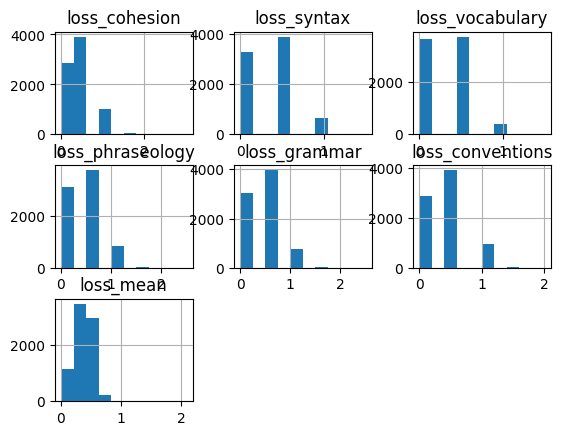

In [14]:
df.hist(['loss_cohesion', 'loss_syntax', 'loss_vocabulary', 'loss_phraseology', 'loss_grammar', 'loss_conventions', 'loss_mean'])

In [1]:
from transformers import AutoTokenizer, TFT5EncoderModel

tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = TFT5EncoderModel.from_pretrained("t5-small")

input_ids = tokenizer(
    "Studies have been shown that owning a dog is good for you", return_tensors="tf"
).input_ids  # Batch size 1
outputs = model(input_ids)


2024-01-12 09:35:11.480364: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 09:35:11.480386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 09:35:11.480910: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 09:35:11.874362: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2024-01-12 09:35:40.213606: W external/local_xla/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:504] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-12.2
  /usr/local/cuda
  /home/yuuhanase/miniconda3/lib/python3.11/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/yuuhanase/miniconda3/lib/python3.11/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.
2024-01-12 09:35:40.254537: W external/local_xla/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:542] libdevice is required by this HLO module but was not found at ./libdevice.10.

UnknownError: Exception encountered when calling layer 'layer_norm' (type TFT5LayerNorm).

{{function_node __wrapped__Rsqrt_device_/job:localhost/replica:0/task:0/device:GPU:0}} JIT compilation failed. [Op:Rsqrt] name: 

Call arguments received by layer 'layer_norm' (type TFT5LayerNorm):
  • hidden_states=tf.Tensor(shape=(1, 2, 512), dtype=float32)